In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.integrate import quad_vec
from scipy.special import jv
from time import time as tm
from scipy.special import genlaguerre
from numpy import pi, exp, sqrt
from scipy.special import eval_genlaguerre
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
def triangle_vertices_cartesian(L):
    """Вершины равностороннего треугольника со стороной L"""
    R = L / np.sqrt(3)
    return np.array([
        [R * np.cos(0), R * np.sin(0)],
        [R * np.cos(2*np.pi/3), R * np.sin(2*np.pi/3)],
        [R * np.cos(4*np.pi/3), R * np.sin(4*np.pi/3)]
    ])

def point_inside_triangle(x, y, vertices):
    """Проверка принадлежности точки треугольнику"""
    v1, v2, v3 = vertices
    cross1 = (v2[0]-v1[0])*(y-v1[1]) - (v2[1]-v1[1])*(x-v1[0])
    cross2 = (v3[0]-v2[0])*(y-v2[1]) - (v3[1]-v2[1])*(x-v2[0])
    cross3 = (v1[0]-v3[0])*(y-v3[1]) - (v1[1]-v3[1])*(x-v3[0])
    return (cross1 >= 0) == (cross2 >= 0) == (cross3 >= 0)

def angular_part(x, y, m):
    """Вычисляет угловую часть e^{imφ} в декартовых координатах"""
    rho = np.sqrt(x**2 + y**2)
    if m >= 0:
        return (x + 1j*y)**m / (rho**m if m != 0 else 1)
    else:
        return (x - 1j*y)**abs(m) / (rho**abs(m))

def compute_bessel_diffraction(vertices, X, Y, z, k, k_z, m_target, N_samples=100):
    """Вычисление дифракции Бесселя с оптимизацией памяти"""
    x_min, y_min = np.min(vertices, axis=0)
    x_max, y_max = np.max(vertices, axis=0)
    x_ap, y_ap = np.meshgrid(np.linspace(x_min, x_max, N_samples),
                            np.linspace(y_min, y_max, N_samples))
    dx = (x_max - x_min) / (N_samples - 1)
    dy = (y_max - y_min) / (N_samples - 1)

    # Маска для точек внутри треугольника
    mask = np.vectorize(point_inside_triangle, excluded=['vertices'])(x_ap, y_ap, vertices=vertices)

    # Вычисления только для точек внутри
    x_p = x_ap[mask]
    y_p = y_ap[mask]

    # Векторизованные вычисления
    R = np.sqrt(z**2 + (X - x_p[:, None, None])**2 + (Y - y_p[:, None, None])**2)
    R = np.where(R < 1e-10, 1e-10, R)  # Избегаем деления на ноль

    kappa = np.sqrt(k**2 - k_z**2)
    angular_part_val = angular_part(x_p, y_p, m_target)
    bessel_part = jv(abs(m_target), kappa * np.sqrt(x_p**2 + y_p**2))
    exp_part = np.exp(1j * k * R)
    factor = (1j*k - 1/R) * z/R + 1j*k_z

    psi = np.sum(bessel_part[:, None, None] * angular_part_val[:, None, None] * exp_part * factor / (4 * np.pi * R) * dx * dy, axis=0)

    return np.abs(psi)**2

In [4]:
# Параметры расчета
#me = 0.511e6           # масса электрона (эВ)
#E_k = 100e3            # кинетическая энергия (эВ)

#Релятивизм/полурелятивизм
#E = 1 + E_k / me       # полная энергия
#k = sqrt(E**2 - 1)     # волновой вектор

#Не релятивизм
#k = sqrt(2*E_k/me)

lambda_e = 0.5e-6      # длина волны фотона, м
k = 2 * np.pi / lambda_e
theta = 0.00001
k_z = k * np.cos(theta)
kappa_2 = k * theta

lambda_c = 386e-15

L = 7*lambda_e            # сторона треугольника, м
z = 40*lambda_e               # расстояние до экрана, м
b = 4*lambda_e            # половина screen_extent, м
N_xy = 200
N_samples = 200

# Сетка наблюдения
x = np.linspace(-b/2, b/2, N_xy)
y = np.linspace(-b/2, b/2, N_xy)
X, Y = np.meshgrid(x, y)
print(1/kappa_2)
#print(k*me*1e-6)
print(kappa_2*0.511e6)
print(lambda_e*lambda_c)

D = L/sqrt(3)       # размер апертуры

# Граница зон Френеля-Фраунгофера
z_fraunhofer = (D**2) / (lambda_e)
print(D*lambda_c*1e9)
print(z_fraunhofer*1e-9)

0.007957747154594765
64214153.839375384
1.93e-19
7.800002136751845e-10
8.166666666666669e-15


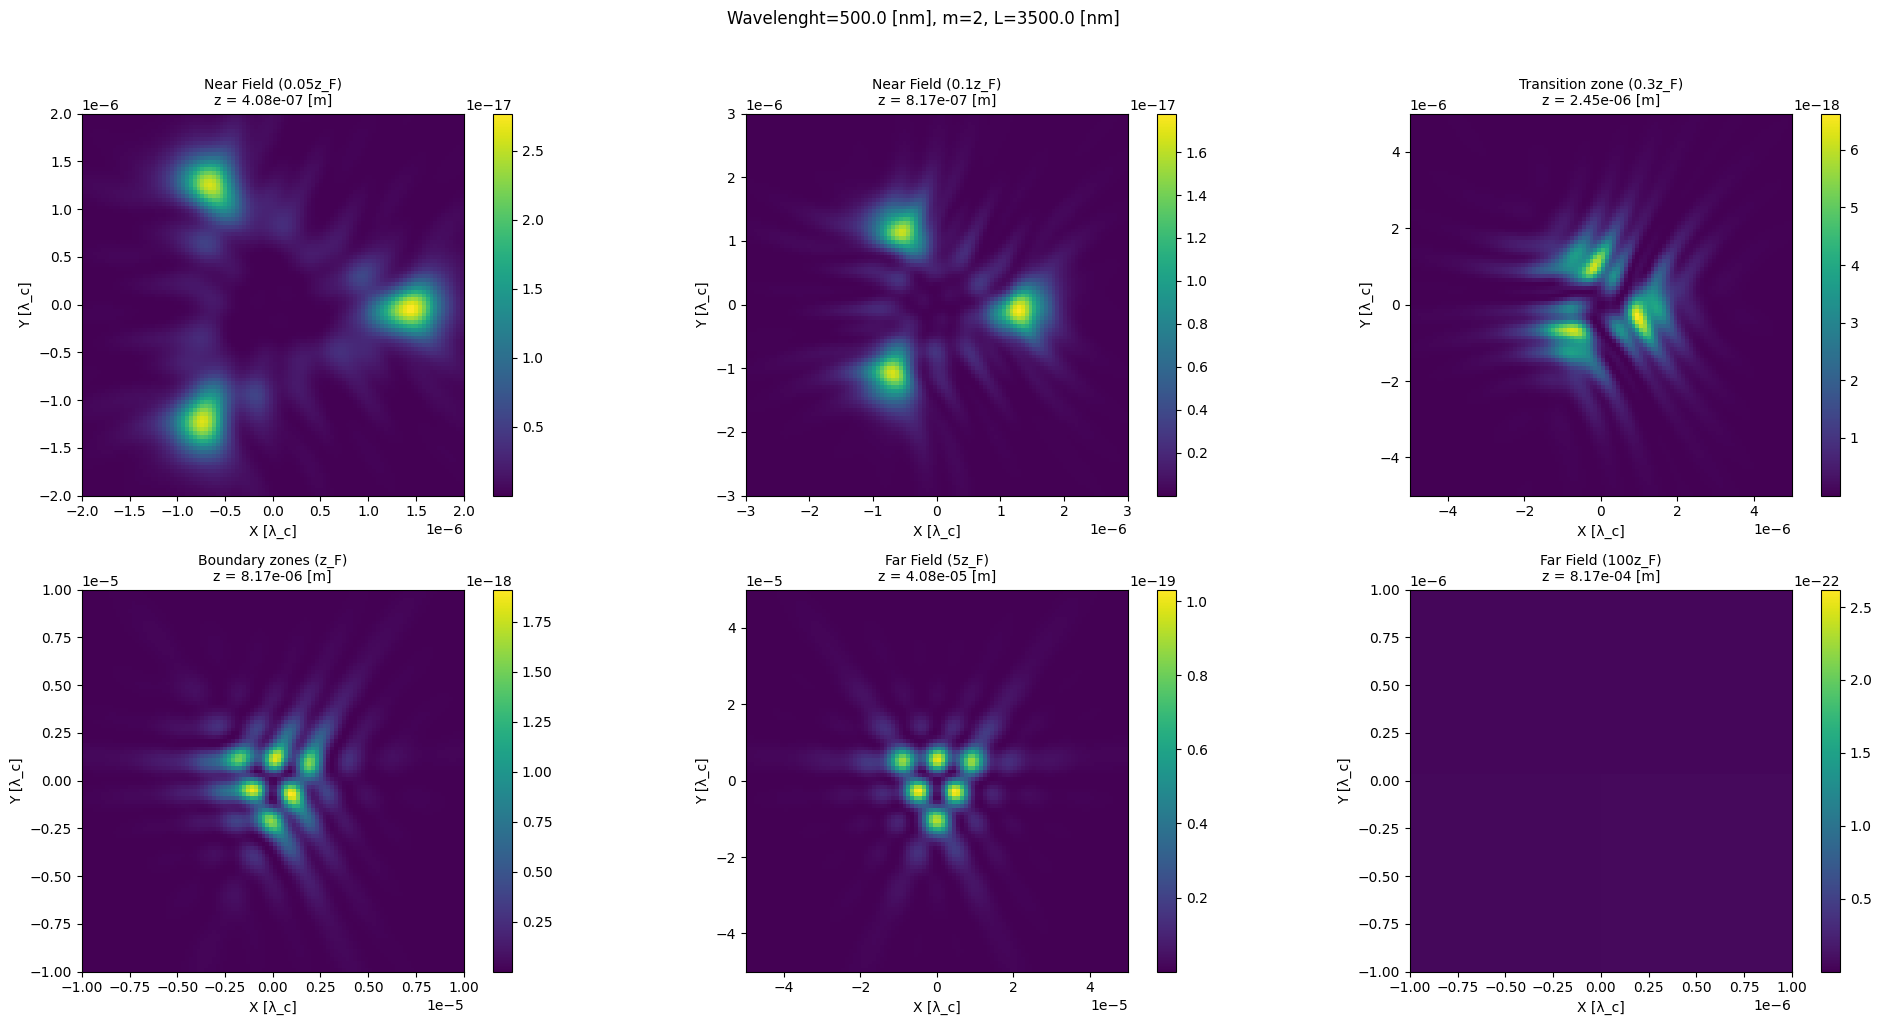

In [6]:
# Параметры для 6 зон
zones = [
    {"z": 0.05 * z_fraunhofer, "b_scale": 0.2, "label": "Near Field (0.05z_F)"},
    {"z": 0.1 * z_fraunhofer, "b_scale": 0.3, "label": "Near Field (0.1z_F)"},
    {"z": 0.3 * z_fraunhofer, "b_scale": 0.5, "label": "Transition zone (0.3z_F)"},
    {"z": z_fraunhofer, "b_scale": 1.0, "label": "Boundary zones (z_F)"},
    {"z": 5 * z_fraunhofer, "b_scale": 5.0, "label": "Far Field (5z_F)"},
    {"z": 100 * z_fraunhofer, "b_scale": 100.0, "label": "Far Field (100z_F)"},

]

# Расчет для m=2
m_target = 2
N_xy = 100
N_samples = 100

fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.ravel()

base_b = 20 * lambda_e

for idx, zone in enumerate(zones):
    z = zone["z"]
    b = zone["b_scale"] * base_b  # Масштабируем базовый размер области

    # Сетка наблюдения
    x = np.linspace(-b, b, N_xy)
    y = np.linspace(-b, b, N_xy)
    X, Y = np.meshgrid(x, y)

    # Вершины треугольника
    vertices = triangle_vertices_cartesian(L)

    # Расчет интенсивности
    intensity = compute_bessel_diffraction(vertices, X, Y, z, k, k_z, m_target, N_samples)

    # Визуализация
    im = axes[idx].imshow(intensity, extent=[-b, b, -b, b], cmap='viridis')
    axes[idx].set_title(f"{zone['label']}\nz = {z:.2e} [m]", fontsize=10)
    axes[idx].set_xlabel("X [λ_c]")
    axes[idx].set_ylabel("Y [λ_c]")
    plt.colorbar(im, ax=axes[idx])

# Скрываем последний пустой subplot
for i in range(len(zones), len(axes)):
    axes[i].axis('off')

plt.suptitle(f'Wavelenght={lambda_e*1e9:.1f} [nm], m={m_target}, L={L*1e9:.1f} [nm]', y=1.02)
plt.tight_layout()
plt.xlim(-1e-6, 1e-6)
plt.ylim(-1e-6, 1e-6)
plt.show()